## Baseline
This notebook implments a baseline model, which shows you how to handle the data and to provide a first very simple solution to the problem. You may re-use and modify any part of this notebook.

In [1]:
!pip install torchmetrics --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.2/840.2 kB 9.8 MB/s eta 0:00:00


In [2]:
import os
import csv
import torch
import pickle
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from tqdm.notebook import tqdm
from google.colab import drive
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from torchmetrics import AUROC, F1Score
import matplotlib.pyplot as plt

In [3]:
from google.colab import drive

drive = drive.mount("/content/drive", force_remount=True)
data_dir = 'drive/MyDrive/kaggle_data'

Mounted at /content/drive


In [ ]:
torch.manual_seed(0)

In [24]:
import pandas as pd
# Loading the datasets
train_x_path = '/content/drive/MyDrive/Foundations_DeepLearning/kaggle_data/train_x.csv'
train_y_path = '/content/drive/MyDrive/Foundations_DeepLearning/kaggle_data/train_y.csv'
val_x_path = '/content/drive/MyDrive/Foundations_DeepLearning/kaggle_data/val_x.csv'
val_y_path = '/content/drive/MyDrive/Foundations_DeepLearning/kaggle_data/val_y.csv'
test_x_path = '/content/drive/MyDrive/Foundations_DeepLearning/kaggle_data/test_x.csv'

train_x = pd.read_csv(train_x_path,index_col=0)
train_y = pd.read_csv(train_y_path)
val_x = pd.read_csv(val_x_path,index_col=0)
val_y = pd.read_csv(val_y_path)
test_x = pd.read_csv(test_x_path,index_col=0)


In [5]:
merged_train = pd.concat([train_x, train_y], axis=1)


In [8]:
train_x_index_column = train_x.index
train_x.head()


,string
index,
0,even up here.......BLACKS!
1,Blame men. There's always an excuse to blame ...
2,You have no business making any comments on th...
3,"""Let's get the black folks and the white folks..."
4,I guess the issue is people not willing to put...


In [ ]:
train_y.head()

,male,female,LGBTQ,christian,muslim,other_religions,black,white,identity_any,severe_toxicity,obscene,threat,insult,identity_attack,sexual_explicit,y,from_source_domain
0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1
3,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
4,1,0,1,1,0,0,0,0,1,0,0,0,1,1,0,1,1


In [9]:
val_x_index_column = val_x.index
val_x.head()


,string
index,
0,Why is this black racist crap still on the G&M...
1,And the woman exposing herself saying grab thi...
2,You're a troll.\n\nYou're not 907AK.\n\nYou're...
3,You sound like a terrorist.
4,"When it all goes to crap, better to punch up i..."


In [ ]:
val_y.head()

,male,female,LGBTQ,christian,muslim,other_religions,black,white,identity_any,severe_toxicity,obscene,threat,insult,identity_attack,sexual_explicit,y,from_source_domain
0,0,0,0,0,0,0,1,1,1,0,0,0,1,1,0,1,0
1,0,1,0,0,0,0,0,0,1,0,1,0,0,0,1,1,0
2,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
3,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
4,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0


In [ ]:
print(val_y.isnull().any(axis=1).sum())
print(train_y.isnull().any(axis=1).sum())



0
0


In [ ]:
#Finding maximum number of words in any message
word_counts = train_x["string"].apply(lambda x: len(x.split()))
df_word_counts = pd.DataFrame({"Word Count": word_counts})
print(max(df_word_counts["Word Count"]))

word_counts_val = val_x["string"].apply(lambda x: len(x.split()))
df_word_counts_val = pd.DataFrame({"Word Count": word_counts_val})
print(max(df_word_counts_val["Word Count"]))

word_counts_test = test_x["string"].apply(lambda x: len(x.split()))
df_word_counts_test = pd.DataFrame({"Word Count": word_counts_test})
print(max(df_word_counts_test["Word Count"]))


214
209
209


In [ ]:
train_x.head()

,string
index,
0,even up here blacks
1,blame men there is always an excuse to blame m...
2,you have no business making any comments on th...
3,let is get the black folks and the white folks...
4,i guess the issue is people not willing to put...


In [ ]:
train_x.shape

(274210, 1)

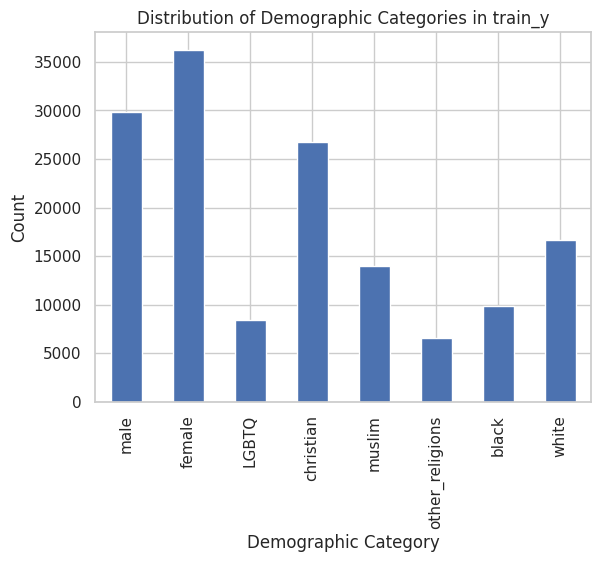

In [25]:
demographic_categories = ['male', 'female', 'LGBTQ', 'christian', 'muslim',
                          'other_religions', 'black', 'white']
train_y[demographic_categories].sum().plot(kind='bar')
plt.xlabel('Demographic Category')
plt.ylabel('Count')
plt.title('Distribution of Demographic Categories in train_y')
plt.show()


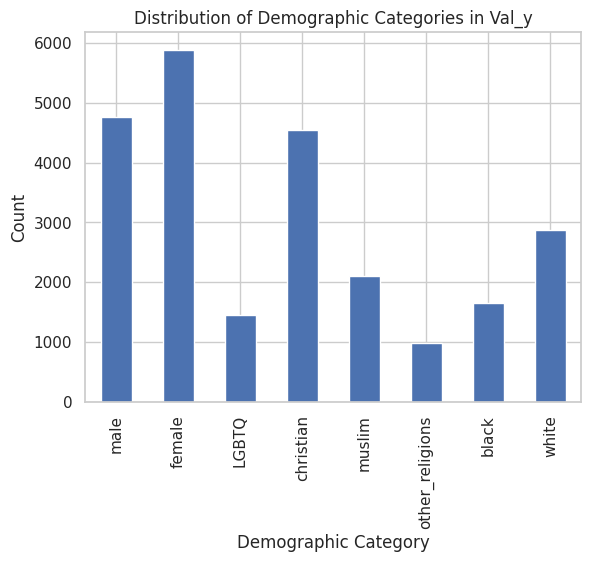

In [26]:
demographic_categories = ['male', 'female', 'LGBTQ', 'christian', 'muslim',
                          'other_religions', 'black', 'white']
val_y[demographic_categories].sum().plot(kind='bar')
plt.xlabel('Demographic Category')
plt.ylabel('Count')
plt.title('Distribution of Demographic Categories in Val_y')
plt.show()


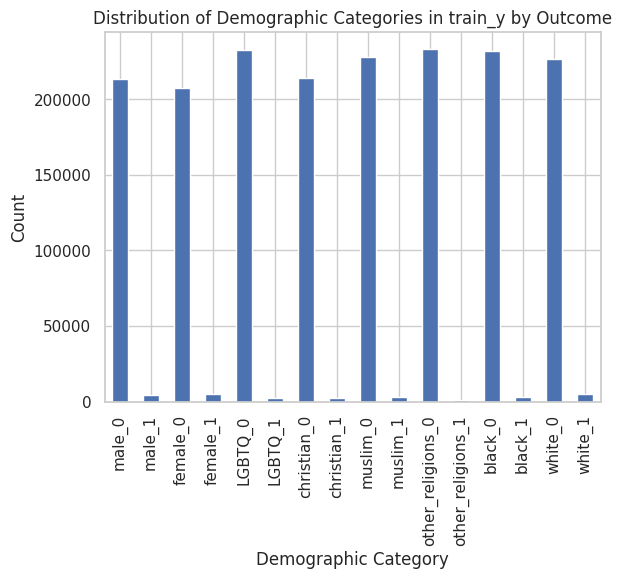

In [27]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming train_y is a pandas DataFrame with a column 'y' that contains the binary outcomes
# and the demographic categories are the columns of the DataFrame.
demographic_categories = ['male', 'female', 'LGBTQ', 'christian', 'muslim', 'other_religions', 'black', 'white']

# Initialize a DataFrame to store the counts
category_counts = pd.DataFrame()

# Calculate the count for each category where y == 0 and y == 1
for category in demographic_categories:
    category_counts[category + '_0'] = (train_y[category] == 0) & (train_y['y'] == 0)
    category_counts[category + '_1'] = (train_y[category] == 1) & (train_y['y'] == 1)

# Sum up the True values for each category (True is treated as 1, False is treated as 0)
category_counts = category_counts.sum()

# Plot
category_counts.plot(kind='bar')
plt.xlabel('Demographic Category')
plt.ylabel('Count')
plt.title('Distribution of Demographic Categories in train_y by Outcome')
plt.show()


In [35]:
# Demographic categories
demographic_categories = ['male', 'female', 'LGBTQ', 'christian', 'muslim', 'other_religions', 'black', 'white']

# Create a DataFrame to store the counts
counts_df = pd.DataFrame(index=demographic_categories, columns=['Toxic (1)', 'Non-Toxic (0)'])

# Iterate through each demographic category
for category in demographic_categories:
    # Calculate the sum of toxic (1) and non-toxic (0) comments in each category
    toxic_count = train_y[(train_y[category] == 1) & (train_y['y'] == 1)].shape[0]
    non_toxic_count = train_y[(train_y[category] == 1) & (train_y['y'] == 0)].shape[0]

    # Store the counts in the DataFrame
    counts_df.loc[category] = [toxic_count, non_toxic_count]

# Display the resulting DataFrame
print(counts_df)


                Toxic (1) Non-Toxic (0)
male                 4437         25373
female               4962         31282
LGBTQ                2265          6155
christian            2446         24292
muslim               3125         10829
other_religions      1003          5541
black                3111          6785
white                4682         12016


In [36]:
# Initialize a dictionary to store the results for categories where the value is 1
category_counts = {}

for category in demographic_categories:
    # Filter the data for the category being 1
    filtered_data = merged_train[merged_train[category] == 1]

    # Count the number of 0 and 1 labels for the filtered category
    count = filtered_data['y'].value_counts().sort_index()

    # Calculate the percentage
    percentage = (count / count.sum()) * 100

    # Store the results in the dictionary
    category_counts[category] = pd.DataFrame({'Count': count, 'Percentage': percentage}, index=[0, 1])

# To access the count and percentage where each category is 1, use category_counts_1[<category_name>]
# For example, category_counts_1['male'] will provide the results for the 'male' category.
for category, data in category_counts.items():
    print(f"{category}:\n{data}\n")

male:
   Count  Percentage
0  26363   84.423736
1   4864   15.576264

female:
   Count  Percentage
0  32003   85.964865
1   5225   14.035135

LGBTQ:
   Count  Percentage
0   7278    72.64198
1   2741    27.35802

christian:
   Count  Percentage
0  24747   90.548847
1   2583    9.451153

muslim:
   Count  Percentage
0  11042   77.238388
1   3254   22.761612

other_religions:
   Count  Percentage
0   5698   84.215194
1   1068   15.784806

black:
   Count  Percentage
0   8684   68.324154
1   4026   31.675846

white:
   Count  Percentage
0  15337   71.822609
1   6017   28.177391



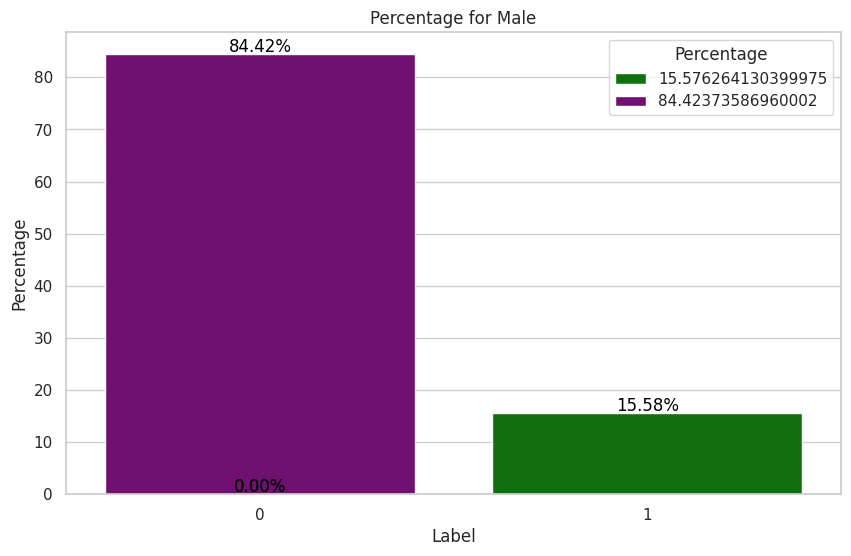

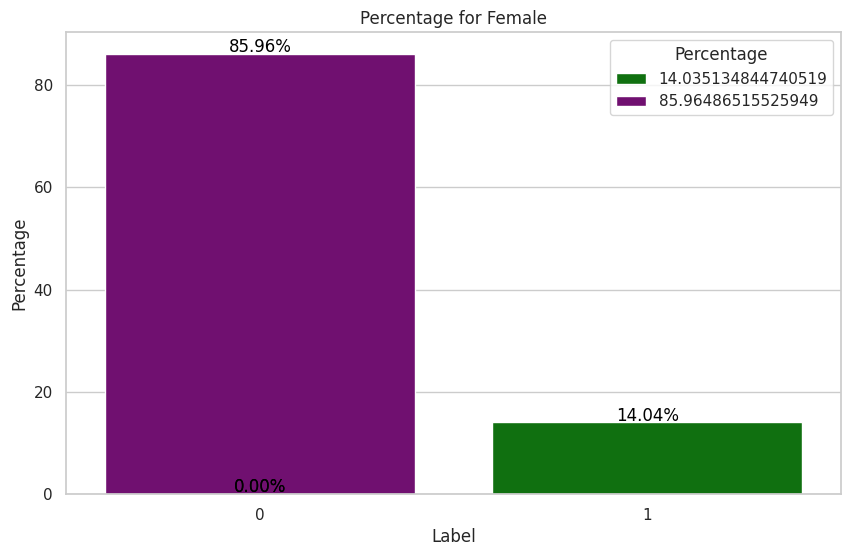

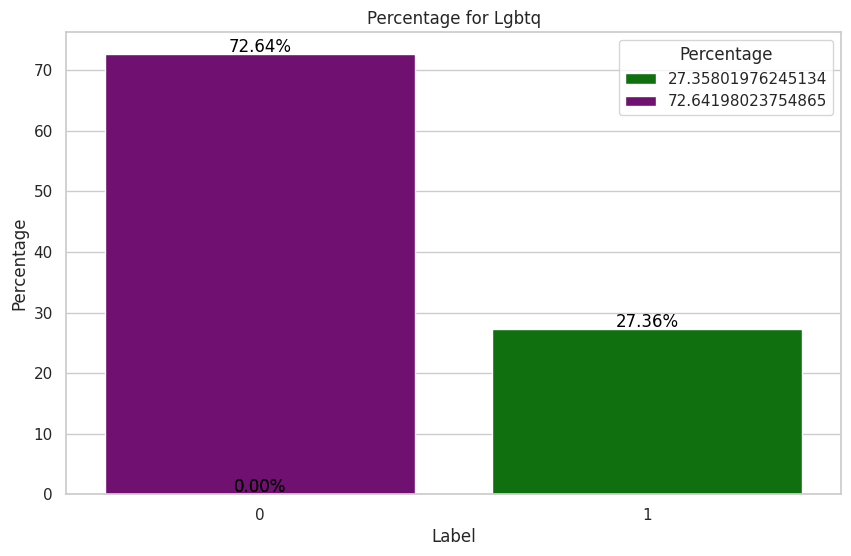

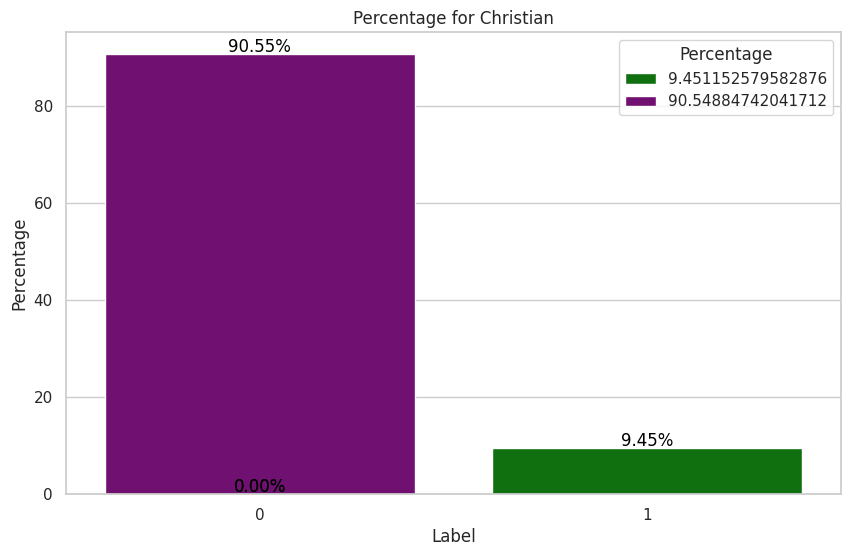

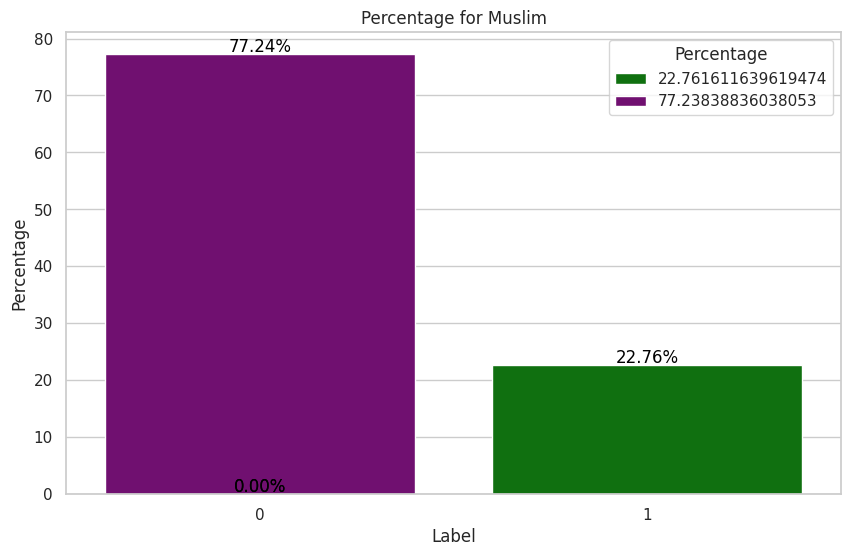

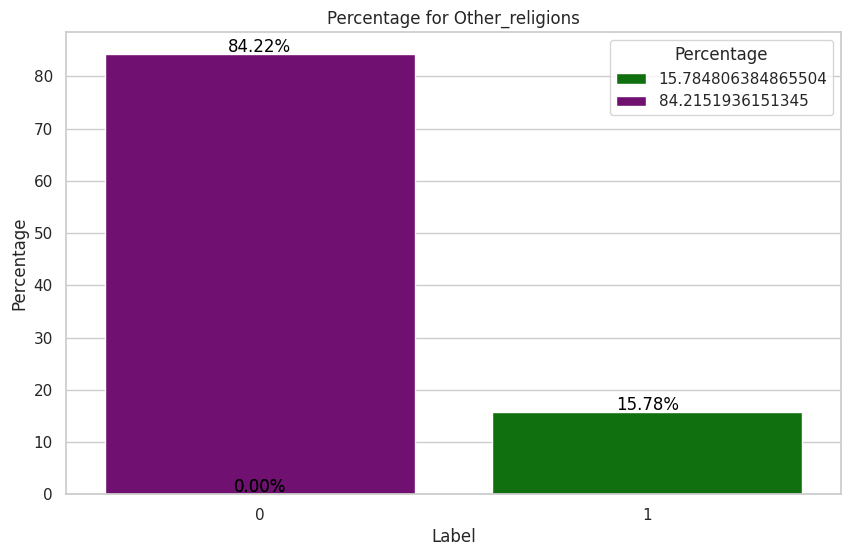

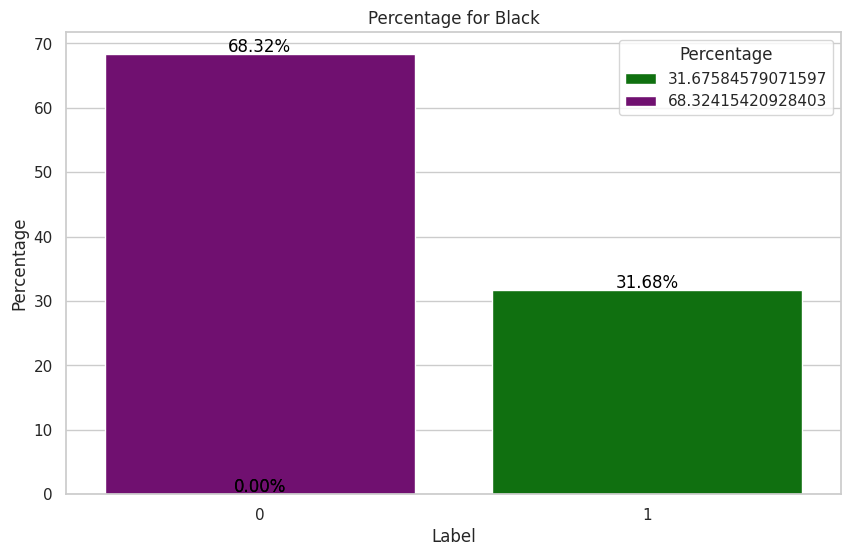

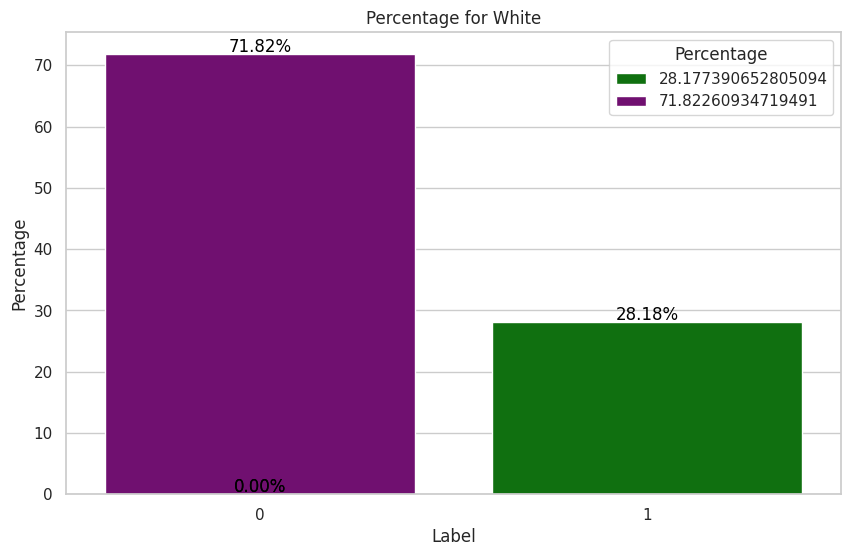

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the aesthetic style of the plots
sns.set(style="whitegrid")

# Loop through each demographic category to create separate plots for percentage
for category in demographic_categories:
    # Data for the category where it is '1'
    data = category_counts[category]

    # Create a new figure with one subplot for percentage
    fig, ax = plt.subplots(figsize=(10, 6))  # Adjust the figsize as per your preference

    # Plot for percentage
    sns.barplot(x=data.index, y='Percentage', data=data, ax=ax, hue='Percentage', palette=["green", "purple"])
    ax.set_title(f'Percentage for {category.capitalize()}')
    ax.set_xlabel('Label')
    ax.set_ylabel('Percentage')

    # Add percentage values to the bars
    for p in ax.patches:
        ax.annotate(f'{p.get_height():.2f}%', (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', fontsize=12, color='black', xytext=(0, 5),
                    textcoords='offset points')

    # Display the plot for the current category
    plt.show()


In [39]:
# Checking the class distribution in train_y for each category
class_distribution = train_y.sum().sort_values(ascending=False)
print("Class Distribution", class_distribution)

Class Distribution from_source_domain    269038
identity_any          113470
female                 36244
y                      30515
male                   29810
christian              26738
insult                 18473
white                  16698
muslim                 13954
black                   9896
LGBTQ                   8420
identity_attack         7802
other_religions         6544
obscene                 1683
sexual_explicit         1347
threat                   659
severe_toxicity            7
dtype: int64


# Data Preprocessing

In [28]:
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase


We initially tried to remove all stopwords to help improve the computational efficiency but we later found out that BERT performs better with these context specific words and hence removed it from the final implementation

In [29]:
stopwords= ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"]



In [33]:
from tqdm import tqdm
def sentence_processor(df):
    preprocessed_comments_train = []
    # tqdm is for printing the status bar
    for sentence in tqdm(df['string'].values):
        sent = decontracted(sentence.lower())
        sent = sent.replace('\r', ' ')
        sent = sent.replace('\"', ' ')
        sent = sent.replace('\n', ' ')
        sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
        sent = ' '.join(e for e in sent.split() if e not in stopwords)
        preprocessed_comments_train.append(sent.lower().strip())
    return preprocessed_comments_train

train_x['string'] = sentence_processor(train_x)
val_x['string'] = sentence_processor(val_x)
test_x['string'] = sentence_processor(test_x)
#merged_train['string'] = sentence_processor(test_x)


100%|██████████| 133782/133782 [00:18<00:00, 7272.84it/s]


In [34]:
# Initialize a dictionary to store the word counts for each demographic category
word_counts = {}

# Loop through each demographic category
for category in demographic_categories:
    # Filter the data for the category where y=1
    filtered_data = merged_train[(merged_train[category] == 1) & (merged_train['y'] == 1)]

    # Concatenate all the strings for the filtered category
    concatenated_strings = ' '.join(filtered_data['string'])

    # Split the concatenated strings into individual words
    words = concatenated_strings.split()

    # Count the occurrence of each word
    word_count = pd.Series(words).value_counts().head(20)

    # Store the word counts in the dictionary
    word_counts[category] = word_count

# Print the word counts for each demographic category
for category, count in word_counts.items():
    print(f"Most common words for {category}:")
    print(count)
    print()


Most common words for male:
the     12994
a        8573
to       8535
and      8488
of       7386
is       5798
in       4435
that     4208
are      3396
you      3391
for      3297
I        2832
not      2241
with     2206
have     2111
be       2056
as       1916
it       1864
on       1856
who      1841
dtype: int64

Most common words for female:
the      14476
to        9907
and       9732
a         9170
of        8247
is        6217
in        5102
that      4694
for       3642
you       3634
are       3630
I         3316
women     2799
with      2538
not       2521
have      2376
be        2314
as        2149
who       2132
on        2093
dtype: int64

Most common words for LGBTQ:
the     7236
to      4775
and     4335
of      3924
a       3894
is      3405
that    2576
in      2461
are     1931
you     1725
for     1675
I       1523
not     1365
gay     1337
be      1256
with    1199
they    1143
have    1113
it      1112
as      1109
dtype: int64

Most common words for christian

Since we found that the classes LGBTQ, Black and White were consistently performing worse despite all our best efforts, we decided to artificially populate these datasets with augmented text paraphrasing. This was convenient since the paraphrased texts would also follow the same multiclass labels

In [ ]:
#!pip install nlpaug
import nlpaug.augmenter.word as naw
import time as time

def augment_text_with_distilbert(text, num_augmented_sentences=1):
    # Initialize the DistilBERT augmenter
    augmenter = naw.ContextualWordEmbsAug(model_path='distilbert-base-uncased', action="substitute")

    # Generate augmented texts

    # Your code to time goes here
    augmented_texts = [augmenter.augment(text) for _ in range(num_augmented_sentences)]
    return augmented_texts


#Merge train_x and train_y
merged_train_black = pd.concat([train_x, train_y], axis=1)
merged_train_black=merged_train_black[merged_train_black["black"]==1]
print(merged_train_black.shape)

start_time = time.time()
for i in range(1000):
    try:
      print(i,merged_train_black.shape[0])
      #randomly select a row from merged_train_black
      random_row = merged_train_black.sample(n=1)
      original_text = random_row['string'].iloc[0]
      #print(original_text)
      augmented_texts = augment_text_with_distilbert(original_text, num_augmented_sentences=1)
      #change the value of string to 'random'
      print(augmented_texts[0][0])
      random_row['string'] = augmented_texts[0][0]
      merged_train_black = pd.concat([merged_train_black, random_row], ignore_index=True)
    except:
      continue


end_time = time.time()
elapsed_time = end_time - start_time
print(f"The code ran for {elapsed_time} seconds")
merged_train_black.to_csv('C:/Users/nfran/Desktop/Labs/Foundations Deep Learning/toxic-comment-classification-dsba-2023-2/Results/train_black_local.csv', index=False)


# Model Creation

In [14]:
def worst_group_accuracy(prediction, y):
    """
        Compute the worst group accuracy, with the groups being defined by ['male', 'female', 'LGBTQ',
        'christian', 'muslim', 'other_religions', 'black', 'white'] for positive and negative toxicity.
        arguments:
            prediction [pandas.DataFrame]: dataframe with 2 columns (index and pred)
            y [pandas.DataFrame]: dataframe containing the metadata
        returns:
            wga [float]: worst group accuracy
    """
    y.loc[prediction.index, 'pred'] = prediction.pred

    categories = ['male', 'female', 'LGBTQ', 'christian', 'muslim', 'other_religions', 'black', 'white']
    accuracies_dict = {}
    for category in categories:
        for label in [0, 1]:
            group = y[y[category] == label]
            group_accuracy = (group['y'] == (group['pred'] > 0.5)).mean()
            # Store accuracy in dictionary with a tuple key (category, label)
            accuracies_dict[(category, label)] = group_accuracy

    return accuracies_dict

In [6]:
import torch
from transformers import DistilBertForSequenceClassification, DistilBertTokenizerFast

#train_x
#val_x
#test_x
#train_y
#val_y


# Initialize the tokenizer
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=1)

# Move the model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)



/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

In [10]:
# Tokenize the training and validation text data
train_x_tokenized = tokenizer(list(train_x['string']), truncation=True, padding=True, max_length=512, return_tensors="pt")
val_x_tokenized = tokenizer(list(val_x['string']), truncation=True, padding=True, max_length=512, return_tensors="pt")

#convert index to tensor
train_x_index_tensor = torch.tensor(train_x_index_column)
val_x_index_tensor = torch.tensor(val_x_index_column)

# Convert labels to PyTorch tensors
train_y_tensor = torch.tensor(train_y['y'].values)
val_y_tensor = torch.tensor(val_y['y'].values)

In [ ]:
print(train_x_tokenized['input_ids'].shape)
print(train_x_tokenized['attention_mask'].shape)
print(train_y_tensor.shape)

We experimented with Batch_sizes of 8,16 and 24. It was not possible to go higher than this without it crashing the Kernel. We found that the batch_size 16 was giving the best results

In [11]:
from torch.utils.data import DataLoader, TensorDataset

# Creating TensorDatasets
train_dataset = TensorDataset(train_x_tokenized['input_ids'], train_x_tokenized['attention_mask'], train_y_tensor, train_x_index_tensor)
val_dataset = TensorDataset(val_x_tokenized['input_ids'], val_x_tokenized['attention_mask'], val_y_tensor, val_x_index_tensor)

# Creating Data Loaders
batch_size = 16  # You can adjust the batch size according to your system's capabilities

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)



We chose BCEwithLogitsLoss because it was seamless to implement with DistilBert and is a very good choice for Binary Classification problems.

The Model seemed to perform best at max of 1 or 2 epochs and would always overfit after.

As for the learning rate, we were able to try a variety of learning rates ranging from 2e-5 to 5e-5. We found that somewhere between 2.5 to 3 was giving us the best results.

In [ ]:
from tqdm import tqdm
from transformers import AdamW
from torch.nn import BCEWithLogitsLoss

# Initialize the loss function
loss_fn = BCEWithLogitsLoss()

# Optimizer
optimizer = AdamW(model.parameters(), lr=4.5e-5)
model.load_state_dict(torch.load('/content/model_weights_0.pth'))

# Assuming you have defined num_epochs, model, train_loader, val_loader, optimizer, and device
num_epochs=3

for epoch in range(1,num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    print('-' * 10)

    # Training Phase
    model.train()
    total_train_loss = 0

    for batch in tqdm(train_loader, desc=f"Training Epoch {epoch+1}"):
        batch = [b.to(device) for b in batch]
        b_input_ids, b_input_mask, b_labels, idx = batch

        # Convert labels to float to match the expected dtype for BCEWithLogitsLoss
        b_labels = b_labels.float()

        model.zero_grad()

        # Forward pass without labels argument
        outputs = model(b_input_ids, attention_mask=b_input_mask)
        logits = outputs.logits

        # Compute the loss using BCEWithLogitsLoss
        loss = loss_fn(logits.view(-1), b_labels)
        total_train_loss += loss.item()

        # Backward pass
        loss.backward()
        optimizer.step()

    avg_train_loss = total_train_loss / len(train_loader)
    print(f"Average training loss: {avg_train_loss:.4f}")

    # Validation Phase
    model.eval()
    total_eval_loss = 0
    total_eval_accuracy = 0

    predictions = []

    for batch in tqdm(val_loader, desc=f"Validation Epoch {1}"):
        batch = [b.to(device) for b in batch]
        b_input_ids, b_input_mask, b_labels, idx = batch
        # Convert labels to float for evaluation
        b_labels = b_labels.float()

        with torch.no_grad():
            # Forward pass without labels argument
            outputs = model(b_input_ids, attention_mask=b_input_mask)
            logits = outputs.logits

            # Compute the loss using BCEWithLogitsLoss
            loss = loss_fn(logits.view(-1), b_labels)
            total_eval_loss += loss.item()

            # Calculate the accuracy
            preds = torch.sigmoid(logits).round()  # Convert logits to probabilities and then to 0 or 1
            total_eval_accuracy += (preds.view(-1) == b_labels).sum().item()

            # Store predictions and indices for each prediction and convert it into a DataFrame
            predictions.extend(zip(idx.cpu().numpy(), preds.cpu().numpy()))

    avg_val_loss = total_eval_loss / len(val_loader)
    print(f"Average validation loss: {avg_val_loss:.4f}")

    # Calculate validation accuracy
    validation_accuracy = total_eval_accuracy / (len(val_loader) * batch_size)
    print(f"Validation Accuracy: {validation_accuracy:.4f}")

    predictions_df = pd.DataFrame(predictions, columns=['index', 'pred'])
    predictions_df.set_index('index', inplace=True)
    predictions_df['pred'] = predictions_df['pred'].apply(lambda x: x[0] if isinstance(x, np.ndarray) else x)#predictions_df.shape

    # Calculate Worst Group Accuracy
    wga = worst_group_accuracy(predictions_df, val_y)
    print("wga:",wga)


    torch.save(model.state_dict(), f'model_weights_{epoch}.pth')


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 2/3
----------


Training Epoch 2: 100%|██████████| 17512/17512 [43:48<00:00,  6.66it/s]


Average training loss: 0.1583


Validation Epoch 1: 100%|██████████| 2824/2824 [01:48<00:00, 26.04it/s]


Average validation loss: 0.1663
Validation Accuracy: 0.9371
wga: {('male', 0): 0.9389583075590746, ('male', 1): 0.9221406086044072, ('female', 0): 0.9400341062383873, ('female', 1): 0.9181802749957563, ('LGBTQ', 0): 0.9385220593280424, ('LGBTQ', 1): 0.8970487302676733, ('christian', 0): 0.9370662072360325, ('christian', 1): 0.9382417582417583, ('muslim', 0): 0.9418388669607616, ('muslim', 1): 0.8421800947867298, ('other_religions', 0): 0.9381363986061456, ('other_religions', 1): 0.8945233265720081, ('black', 0): 0.9381547509648962, ('black', 1): 0.9116222760290557, ('white', 0): 0.9401838678420343, ('white', 1): 0.8929194279734914}
Epoch 3/3
----------


Training Epoch 3:   1%|          | 91/17512 [00:13<43:46,  6.63it/s]


KeyboardInterrupt: 

# EVALUATION

( Our final results were different to these ones, however the weights were lost and we were not able to retain the plot of the rest of the metrics. )

In [17]:
#TESTING THE VALIDATION ACCURACY AND LOAD WEIGHTS

#torch.save(model.state_dict(), 'model_weights_epoch1.pth')
model.load_state_dict(torch.load('/content/drive/MyDrive/Foundations_DeepLearning/model_weights/model_weights.pth'))
from tqdm import tqdm
from transformers import AdamW
from torch.nn import BCEWithLogitsLoss

# Initialize the loss function
loss_fn = BCEWithLogitsLoss()

# Optimizer
optimizer = AdamW(model.parameters(), lr=5e-5)

from sklearn.metrics import precision_score, recall_score, f1_score


# Assuming you have defined num_epochs, model, train_loader, val_loader, optimizer, and device
num_epochs=3
model.eval()
total_eval_loss = 0
total_eval_accuracy = 0

preds_list =[]
labels_list = []
predictions = []

for batch in tqdm(val_loader, desc=f"Validation Epoch {1}"):
    batch = [b.to(device) for b in batch]
    b_input_ids, b_input_mask, b_labels, idx = batch
     #Convert labels to float for evaluation
    b_labels = b_labels.float()

    with torch.no_grad():
        # Forward pass without labels argument
        outputs = model(b_input_ids, attention_mask=b_input_mask)
        logits = outputs.logits

        # Compute the loss using BCEWithLogitsLoss
        loss = loss_fn(logits.view(-1), b_labels)
        total_eval_loss += loss.item()

        # Calculate the accuracy
        preds = torch.sigmoid(logits).round()  # Convert logits to probabilities and then to 0 or 1
        total_eval_accuracy += (preds.view(-1) == b_labels).sum().item()

        preds_list.append(preds.cpu())
        labels_list.append(b_labels.cpu())
        # Store predictions and indices for each prediction and convert it into a DataFrame
        predictions.extend(zip(idx.cpu().numpy(), preds.cpu().numpy()))

preds_flat = np.concatenate([p.numpy() for p in preds_list])
labels_flat = np.concatenate([l.numpy() for l in labels_list])

avg_val_loss = total_eval_loss / len(val_loader)
print(f"Average validation loss: {avg_val_loss:.4f}")

# Calculate validation accuracy
validation_accuracy = total_eval_accuracy / (len(val_loader) * batch_size)
print(f"Validation Accuracy: {validation_accuracy:.4f}")

predictions_df = pd.DataFrame(predictions, columns=['index', 'pred'])
predictions_df.set_index('index', inplace=True)
predictions_df['pred'] = predictions_df['pred'].apply(lambda x: x[0] if isinstance(x, np.ndarray) else x)#predictions_df.shape

# Calculate Worst Group Accuracy
wga = worst_group_accuracy(predictions_df, val_y)
print(f"Worst Group Accuracy: {wga}")


Average validation loss: 0.0000
Validation Accuracy: 0.0000
Worst Group Accuracy: {('male', 0): 0.9182234318940987, ('male', 1): 0.8734522560335781, ('female', 0): 0.9163888111176156, ('female', 1): 0.8942454591750127, ('LGBTQ', 0): 0.9182123824989136, ('LGBTQ', 1): 0.7721345229924502, ('christian', 0): 0.9123554024120109, ('christian', 1): 0.9237362637362637, ('muslim', 0): 0.9193406083120501, ('muslim', 1): 0.7943127962085308, ('other_religions', 0): 0.9145811648640086, ('other_religions', 1): 0.8651115618661258, ('black', 0): 0.9206947252343319, ('black', 1): 0.7239709443099274, ('white', 0): 0.9247512584784818, ('white', 1): 0.7474712242762469}


In [ ]:
# Assuming `predictions_df` is your DataFrame and 'pred' is the column with numpy arrays
#predictions_df['pred'] = predictions_df['pred'].apply(lambda x: x[0] if isinstance(x, np.ndarray) else x)#predictions_df.shape
#tester=pd.DataFrame(val_y['y'])
wga = worst_group_accuracy(predictions_df, val_y)
print(wga)


{('male', 0): 0.9255721885438575, ('male', 1): 0.8927597061909759, ('female', 0): 0.9244572272137239, ('female', 1): 0.9064674927856051, ('LGBTQ', 0): 0.926080095144432, ('LGBTQ', 1): 0.8030199039121483, ('christian', 0): 0.9211174009352695, ('christian', 1): 0.930989010989011, ('muslim', 0): 0.926932899930346, ('muslim', 1): 0.8236966824644549, ('other_religions', 0): 0.9229307145766393, ('other_religions', 1): 0.8853955375253549, ('black', 0): 0.9281841573240214, ('black', 1): 0.7621065375302664, ('white', 0): 0.9316758443031692, ('white', 1): 0.7809557028252528}


In [18]:
precision = precision_score(labels_flat, preds_flat)
f1 = f1_score(labels_flat, preds_flat)

print(f"Precision: {precision:.4f}")
print(f"F1 Score: {f1:.4f}")

recall = recall_score(labels_flat, preds_flat)

print(f"Recall: {recall:.4f}")

Precision: 0.8491
F1 Score: 0.4165
Recall: 0.2760


Confusion Matrix:
[[39877   248]
 [ 3660  1395]]


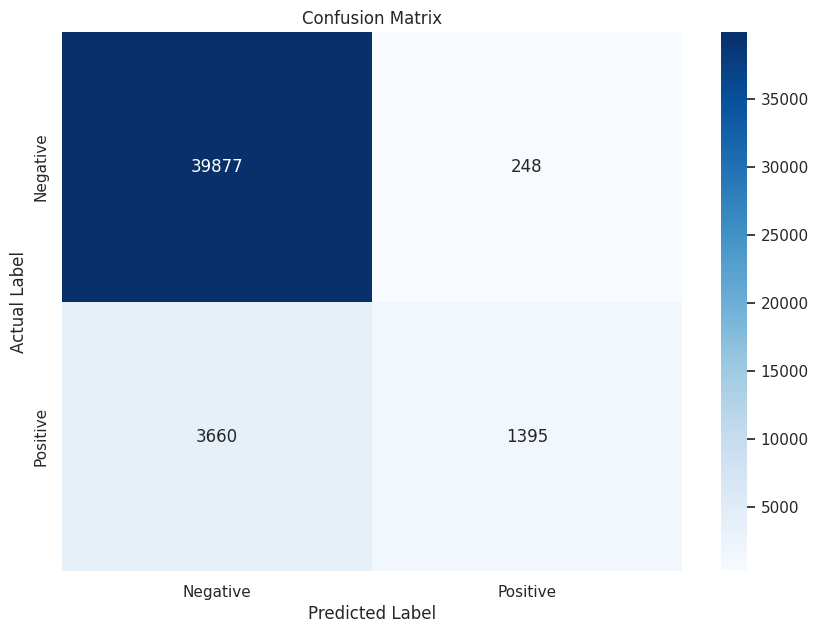

In [22]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you have true labels and predictions in labels_flat and preds_flat arrays
cm = confusion_matrix(labels_flat, preds_flat)

# Print the confusion matrix
print("Confusion Matrix:")
print(cm)

# Optional: Plot the confusion matrix using seaborn for better visualization
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.title("Confusion Matrix")
plt.ylabel("Actual Label")
plt.xlabel("Predicted Label")
plt.show()

In [ ]:
#MAKING PREDICTIONS ON TEST_X
from tqdm import tqdm

# Tokenize the test_x
model.load_state_dict(torch.load('/content/model_weights_1.pth'))

test_x_tokenized = tokenizer(list(test_x['string']), truncation=True, padding=True, max_length=512, return_tensors="pt")


test_x_index_column = test_x.index
#convert index into tensor
test_x_index_tensor = torch.tensor(test_x_index_column)

#creating the test Dataset class
test_dataset = TensorDataset(test_x_tokenized['input_ids'], test_x_tokenized['attention_mask'], test_x_index_tensor)

#Creating the test Dataloader
test_loader = DataLoader(test_dataset, batch_size=batch_size)

model.eval()
total_eval_loss = 0
total_eval_accuracy = 0


predictions = []

for batch in tqdm(test_loader, desc=f"Validation Epoch {1}"):
    batch = [b.to(device) for b in batch]
    b_input_ids, b_input_mask, idx = batch

    with torch.no_grad():
        # Forward pass without labels argument
        outputs = model(b_input_ids, attention_mask=b_input_mask)
        logits = outputs.logits

        # Store predictions and indices for each prediction and convert it into a DataFrame
        preds = torch.sigmoid(logits).round()
        predictions.extend(zip(idx.cpu().numpy(), preds.cpu().numpy()))

predictions_df = pd.DataFrame(predictions, columns=['index', 'pred'])
predictions_df.set_index('index', inplace=True)
predictions_df['pred'] = predictions_df['pred'].apply(lambda x: x[0] if isinstance(x, np.ndarray) else x)#predictions_df.shape





Validation Epoch 1: 100%|██████████| 8362/8362 [05:27<00:00, 25.54it/s]


In [ ]:
predictions_df.head()

,pred
index,
0,1.0
1,0.0
2,0.0
3,1.0
4,0.0


In [ ]:
predictions_df.to_csv('predictions_df_final.csv', index=False)


Once we are happy with our results, we want to make a prediction on the test set. Your submission `.csv` file should contain 2 columns:
- ID: with the id of each prediction (do not shuffle to not mix things up)
- pred: the prediction of the model (thresholded or not)

In [ ]:
pred_df = pd.DataFrame({'ID': indices, 'pred': test_predictions})
pred_df.to_csv('prediction.csv', index=False)

In [ ]:
test_predictions=predictions_df
# Assuming test_predictions is your existing DataFrame
# Add an 'ID' column that matches the index
test_predictions['ID'] = test_predictions.index

# Ensure the order of the columns matches test_predictions_2, with 'ID' first
test_predictions = test_predictions[['ID', 'pred']]
test_predictions.head()
# Now test_predictions should have the same format as test_predictions_2
test_predictions.to_csv('predictions_78.csv', index=False)